#### Airbnb in Munich - an analysis

In this jupyter notebook we use CRISP-DM to answer the following questions for the Airbnb data set from munich

- Did the AirbnB business grow and evolve in Munich?
- What are the most popular neighboorhoods in Munich and what makes them popular?
- Can we predict a listing price and what are the most important features to estimate Airbnb rental price?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.model_selection import GridSearchCV

from scipy.stats import skew
import datetime

pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
# Read data from csvs
listings = pd.read_csv("data/listings.csv", low_memory=False)
listings_munich = pd.read_csv("data/listings.csv", low_memory=False)
reviews = pd.read_csv("data/reviews.csv", low_memory=False)
calendar = pd.read_csv("data/calendar.csv", low_memory=False)

# Inspect size of frames review, listings, and calendar
print(f"Munich listings has {listings.shape[0]} rows and {listings.shape[1]} columns")
print(f"Munich reviews  has {reviews.shape[0]}  rows and {reviews.shape[1]}  columns")
print(f"Munich calendar has {calendar.shape[0]} rows and {calendar.shape[1]} columns")

Munich listings has 11128 rows and 106 columns
Munich reviews  has 170796  rows and 6  columns
Munich calendar has 4062391 rows and 7 columns


Understanding the data and its implication to the price

- listings: unique id and detailed information for each place to rent in Munich
- review: include reviewer id and comments to the listing id
- calendar: availablity and price for a specific date

In [3]:
print(f"Columns of munich listing: {listings.columns.values}")
print("\n")
print(f"Columns of munich reviews: {reviews.columns.values}")
print("\n")
print(f"Columns of munich calendar: {calendar.columns.values}")

Columns of munich listing: ['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'security_deposit' 'cle

In [4]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36720,https://www.airbnb.com/rooms/36720,20200524235838,2020-05-25,"Beautiful 2 rooms flat, Glockenbach","Very quiet, yet centrally located 2 rooms apt....","2-Zimmer Altbauwohung Beste Lage, zentral, im ...","Very quiet, yet centrally located 2 rooms apt....",none,Glockenbachviertel area has the hippest restau...,NaN,"Convenient public transport, walking distance ...",NaN,NaN,"Please no smoking in the apartment, and be car...",NaN,NaN,https://a0.muscache.com/im/pictures/4e2a8e2e-d...,NaN,158413,https://www.airbnb.com/users/show/158413,Gabriela,2010-07-05,"Munich, Bavaria, Germany","Hi there, my name is Gabriela. I'm a big trave...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/158413/profil...,https://a0.muscache.com/im/users/158413/profil...,Ludwigsvorstadt - Isarvorstadt,1.00,1.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Munich, Bavaria, Germany",Ludwigsvorstadt - Isarvorstadt,Ludwigsvorstadt-Isarvorstadt,NaN,Munich,Bavaria,80469,Munich,"Munich, Germany",DE,Germany,48.13,11.57,t,Apartment,Entire home/apt,2,1.00,1.00,1.00,Futon,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,W...",614.00,$95.00,$800.00,NaN,$100.00,$30.00,1,$30.00,2,730,2,2,730,730,2.00,730.00,34 months ago,t,0,0,0,0,2020-05-25,25,0,2014-05-09,2017-07-22,98.00,10.00,10.00,10.00,10.00,10.00,9.00,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.34
1,49309,https://www.airbnb.com/rooms/49309,20200524235838,2020-05-26,Sublet - Apartment with Balcony in Downtown (1),we are a young family of 4 and will be travell...,"we offer one very bright room with balcony, a ...",we are a young family of 4 and will be travell...,none,"the neighborhood ""schlachthofviertel"" is one o...","please note, that the room has no curtains and...","the closest subway stop is ""Goetheplatz"", wher...",NaN,"international folks welcome (English, Portugue...",our house rules: - please let us know in advan...,NaN,NaN,https://a0.muscache.com/im/pictures/5578937/1f...,NaN,224802,https://www.airbnb.com/users/show/224802,Damien,2010-09-05,"Munich, Bayern, Germany",Hello there! We love meeting new people and tr...,within a day,100%,0%,f,https://a0.muscache.com/im/users/224802/profil...,https://a0.muscache.com/im/users/224802/profil...,Ludwigsvorstadt - Isarvorstadt,1.00

In [5]:
listings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,"11,128.00","23,169,886.23","12,816,601.60","36,720.00","11,935,518.75","23,290,722.50","35,362,292.25","43,535,486.00"
scrape_id,"11,128.00","20,200,524,235,838.00",0.00,"20,200,524,235,838.00","20,200,524,235,838.00","20,200,524,235,838.00","20,200,524,235,838.00","20,200,524,235,838.00"
thumbnail_url,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium_url,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xl_picture_url,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,"11,128.00","87,624,990.51","92,209,480.60","37,354.00","17,463,283.50","44,331,435.50","143,397,491.75","347,431,547.00"
host_listings_count,"11,121.00",1.86,9.34,0.00,1.00,1.00,2.00,666.00
host_total_listings_count,"11,121.00",1.86,9.34,0.00,1.00,1.00,2.00,666.00
neighbourhood_group_cleansed,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,"11,128.00",48.14,0.03,48.07,48.12,48.14,48.16,48.23


In total we 106 features for the listing dataframe of which some are less inforamtive than others. We decide to drop some beforehand. We will keep the following columsn which we keep in the list `columns_to_keep`



In [6]:
# Missing values
data_info = pd.DataFrame(listings.dtypes).T.rename(index={0: "Data Type"})
data_info = data_info.append(
    pd.DataFrame(listings.isnull().sum() / listings.shape[0] * 100).T.rename(
        index={0: "Missing values in %"}
    )
)
data_info

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
Data Type,int64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,float64,object,object,object,int64,float64,float64,float64,object,object,float64,object,object,object,object,object,int64,object,int64,int64,int64,int64,int64,int64,float64,float64,object,object,int64,int64,int64,int64,object,int64,int64,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,object,object,object,object,int64,int64,int64,int64,float64
Missing values in %,0.0,0.0,0.0,0.0,0.18,5.48,37.47,2.74,0.0,46.69,71.23,38.2,56.34,49.5,51.83,100.0,100.0,0.0,100.0,0.0,0.0,0.06,0.06,0.5,56.38,68.96,68.96,37.76,0.06,0.06,0.06,25.8,0.06,0.06,0.0,0.06,0.06,0.0,0.0,0.0,100.0,0.0,0.58,2.09,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18,0.36,0.68,0.0,0.0,98.63,0.0,90.52,93.78,37.1,31.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.16,24.16,25.77,25.85,25.82,25.87,25.83,25.85,25.87,0.0,99.84,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.16


Review data set

In [7]:
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,36720,12723661,2014-05-09,11840468,Mikhail,I would like to thank Gabriella as her apartme...
1,36720,13147830,2014-05-20,5466213,Kim,Gabriela's place was absolutely fantastic. It...


Calendar data set

In [8]:
calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,222924,2020-05-26,f,$40.00,$40.00,1.00,"1,125.00"
1,36720,2020-05-25,f,$95.00,$95.00,2.00,730.00


In [9]:
colum_list = listings.columns[listings.isnull().mean()>0.5].to_list()
colum_list

['notes',
 'access',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'license',
 'jurisdiction_names']

In [10]:
listings = listings.drop_duplicates()
listings = listings.drop(colum_list, axis=1)
listings = listings.dropna(subset=["price"], axis=0)
listings.shape

(11128, 91)

In [11]:
columns_to_remove_dollar = ["price", "security_deposit", "cleaning_fee", "extra_people"]
for column in columns_to_remove_dollar:
    listings[column] = pd.to_numeric(
        listings[column]
        .str.replace("$", "", regex=True)
        .str.replace(",", "", regex=True)
    )

listings[columns_to_remove_dollar].sort_values(by="price")

,price,security_deposit,cleaning_fee,extra_people
4647,8.00,100.00,25.00,0.00
3282,9.00,NaN,NaN,0.00
10751,10.00,NaN,NaN,0.00
3181,10.00,87.00,NaN,0.00
752,10.00,250.00,NaN,100.00
...,...,...,...,...
6290,"5,000.00",0.00,0.00,0.00
10448,"7,000.00",0.00,0.00,10.00
6571,"8,000.00",300.00,100.00,50.00
7598,"9,000.00",300.00,50.00,25.00


### Question 1: Did the AirbnB business grow and evolve in Munich? 

In order to answer that question we check the number of new listings from the listings dataframe and show how much revenue was created. The later one can be read from the calendar dataframe.

In [12]:
listings['host_since_year']=pd.DatetimeIndex(listings['host_since']).year
listings['host_since_month']=pd.DatetimeIndex(listings['host_since']).month

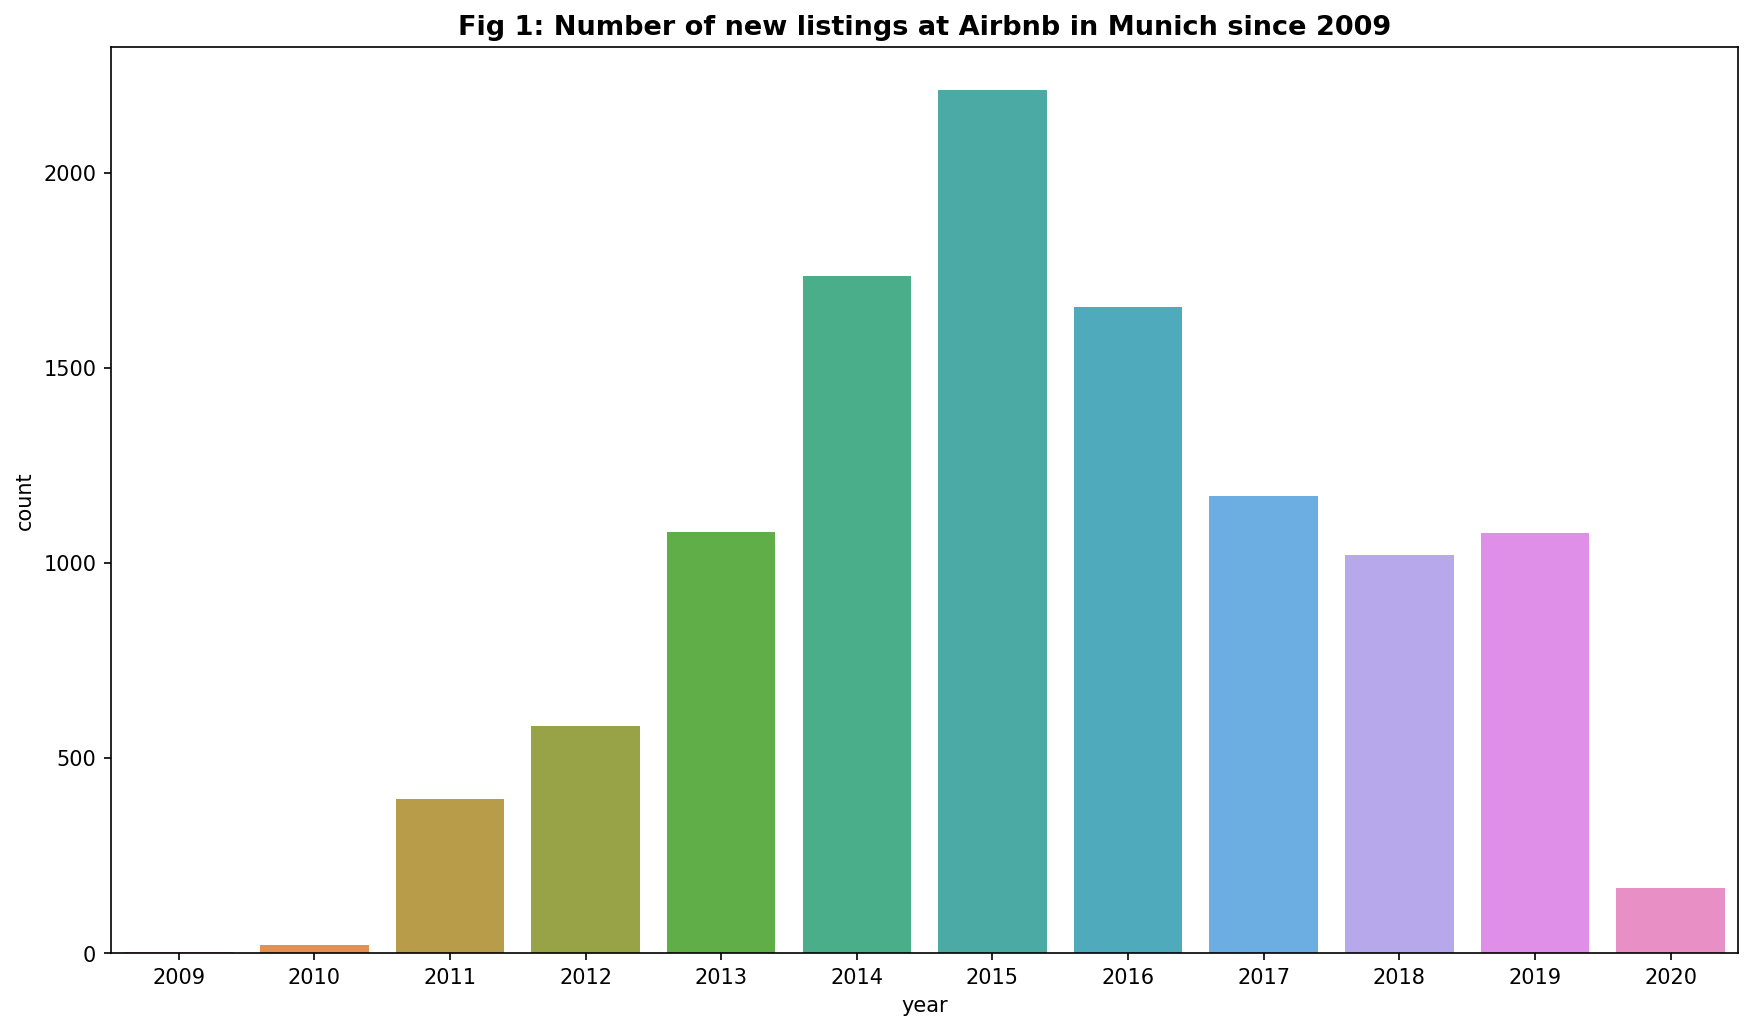

In [13]:
evolution = (
    listings[["host_since_year", "host_id"]]
    .groupby("host_since_year")
    .count()
    .reset_index()
    .rename(columns={"host_since_year": "year", "host_id": "count"})
)
evolution.year = pd.to_numeric(evolution.year, downcast="integer")

fig = plt.figure(dpi=150, figsize=(14,8))
sns.barplot(x="year", y="count", data=evolution).set_title(
    "Fig 1: Number of new listings at Airbnb in Munich since 2009", fontsize=13, weight="bold"
)
fig.savefig("evolution.png")

In [14]:
print(evolution)

    year  count
0   2009      2
1   2010     20
2   2011    396
3   2012    582
4   2013   1080
5   2014   1737
6   2015   2212
7   2016   1657
8   2017   1173
9   2018   1020
10  2019   1076
11  2020    166


In [15]:
calendar["Year"] = pd.DatetimeIndex(calendar["date"]).year
calendar["Month"] = pd.DatetimeIndex(calendar["date"]).month
calendar["Month_Year"] = pd.to_datetime(calendar["date"]).dt.to_period("M")
calendar["Year_Month"] = pd.to_datetime(calendar["date"]).dt.strftime("%Y-%m-01")
calendar["weekday"] = pd.to_datetime(calendar["date"]).dt.day_name()

calendar.price = pd.to_numeric(
    calendar.price.str.replace("$", "", regex=True).replace(",", "", regex=True),
    downcast="float",
)

calendar.adjusted_price = pd.to_numeric(
    calendar.adjusted_price.str.replace("$", "", regex=True).replace(",", "", regex=True),
    downcast="float",
)

In [16]:
calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year,Month,Month_Year,Year_Month,weekday
0,222924,2020-05-26,f,40.00,40.00,1.00,"1,125.00",2020,5,2020-05,2020-05-01,Tuesday
1,36720,2020-05-25,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Monday
2,36720,2020-05-26,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Tuesday
3,36720,2020-05-27,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Wednesday
4,36720,2020-05-28,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
4062386,43426586,2021-05-21,f,16.00,16.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Friday
4062387,43426586,2021-05-22,f,15.00,15.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Saturday
4062388,43426586,2021-05-23,f,15.00,15.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Sunday
4062389,43426586,2021-05-24,f,15.00,15.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Monday


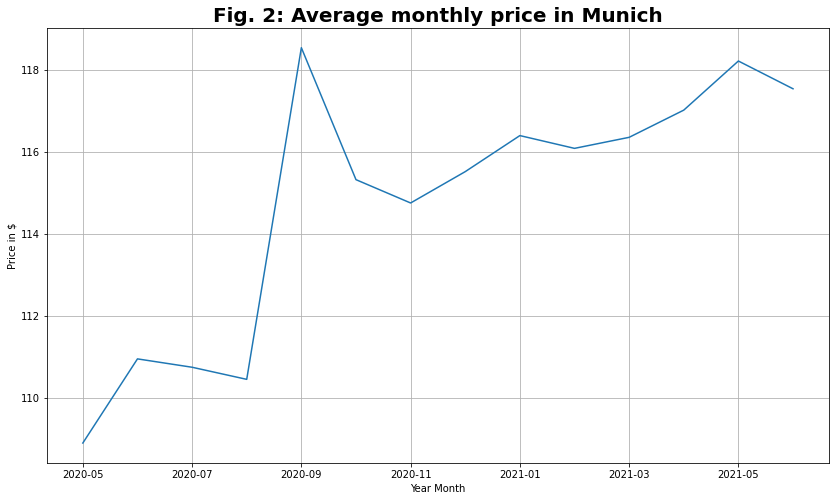

In [17]:
plot_data = (
    calendar[["Year_Month", "price"]]
    .groupby("Year_Month")
    .mean()
    .reset_index()
    .sort_values(by="Year_Month")
)
plot_data.Year_Month = plot_data.Year_Month.str.replace("-01$", "", regex=True)
ax = plot_data.plot(
    x="Year_Month",
    y="price",
    kind="line",
    figsize=(14, 8),
    grid=True,
    xlabel="Year Month",
    ylabel="Price in $"
)
ax.set_title("Fig. 2: Average monthly price in Munich", fontsize=20, weight="bold")
ax.get_legend().remove()
fig = ax.get_figure()
fig.savefig("average_monthly_price.png")

In [18]:
calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year,Month,Month_Year,Year_Month,weekday
0,222924,2020-05-26,f,40.00,40.00,1.00,"1,125.00",2020,5,2020-05,2020-05-01,Tuesday
1,36720,2020-05-25,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Monday
2,36720,2020-05-26,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Tuesday
3,36720,2020-05-27,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Wednesday
4,36720,2020-05-28,f,95.00,95.00,2.00,730.00,2020,5,2020-05,2020-05-01,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
4062386,43426586,2021-05-21,f,16.00,16.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Friday
4062387,43426586,2021-05-22,f,15.00,15.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Saturday
4062388,43426586,2021-05-23,f,15.00,15.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Sunday
4062389,43426586,2021-05-24,f,15.00,15.00,1.00,"1,125.00",2021,5,2021-05,2021-05-01,Monday


### Question 2: What are the most popular neighboorhoods in Munich and what makes them popular?

In order to answer that general question we check the listings for the following more concrete questions:

- In which neighborhoods do we pay the highest price?
- In which neighborhoods are the most appartments enlisted?
- Which neighborhoods have the highest review score for the location?
- Which neighborhoods have the highest review score rating?

In [19]:
neighbourhood = (
    listings[["neighbourhood_cleansed", "id", "price"]]
    .groupby("neighbourhood_cleansed")
    .agg({"id": "count", "price": np.mean})
    .reset_index()
    .rename(columns={"neighbourhood_cleansed": "neighbourhood", "id": "count"})
    .sort_values(by="count", ascending=False)
)

In [20]:
print(f"There are {len(listings['neighbourhood_cleansed'].value_counts())} distinct neighbourhood")

There are 25 distinct neighbourhood


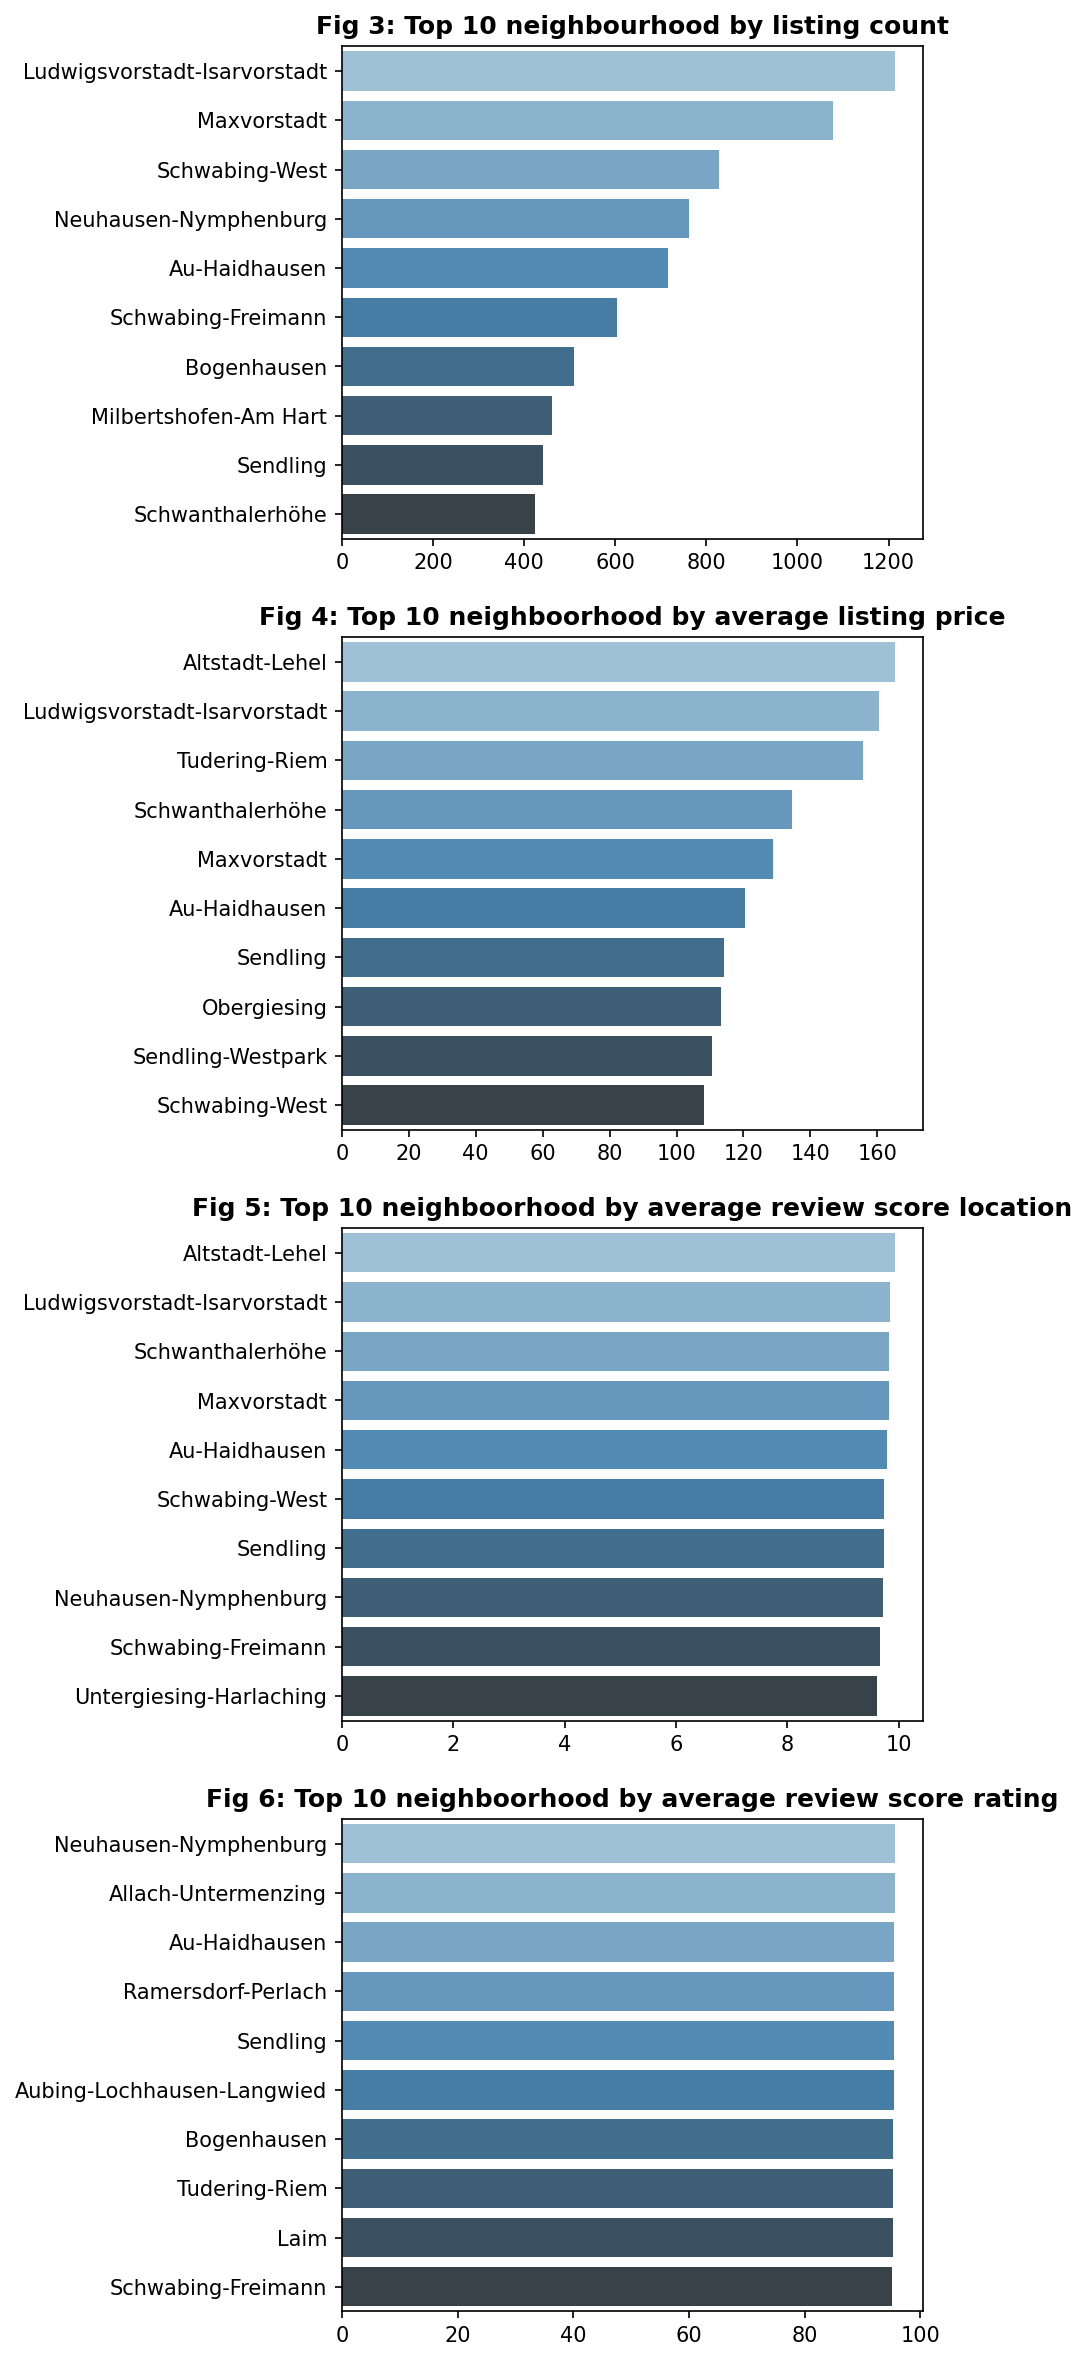

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5, 20), dpi=150)
plot_data = (
    listings[
        [
            "neighbourhood_cleansed",
            "id",
            "price",
            "review_scores_location",
            "review_scores_rating",
        ]
    ]
    .groupby("neighbourhood_cleansed")
    .agg(
        {
            "id": "count",
            "price": "mean",
            "review_scores_location": "mean",
            "review_scores_rating": "mean",
        }
    )
    .reset_index()
)
plot_data.columns = [
    "neighbourhood",
    "listing_count",
    "price",
    "review_scores_location",
    "review_scores_rating",
]
plot_data1 = (
    plot_data[["neighbourhood", "listing_count"]]
    .sort_values(by="listing_count", ascending=False)
    .head(10)
)
plot_data2 = (
    plot_data[["neighbourhood", "price"]]
    .sort_values(by="price", ascending=False)
    .head(10)
)
plot_data3 = (
    plot_data[["neighbourhood", "review_scores_location"]]
    .sort_values(by="review_scores_location", ascending=False)
    .head(10)
)
plot_data4 = (
    plot_data[["neighbourhood", "review_scores_rating"]]
    .sort_values(by="review_scores_rating", ascending=False)
    .head(10)
)

sns.barplot(
    data=plot_data1, y="neighbourhood", x="listing_count", palette="Blues_d", ax=ax1
).set_title("Fig 3: Top 10 neighbourhood by listing count", fontsize=12, weight="bold")

sns.barplot(
    data=plot_data2,
    y="neighbourhood",
    x="price",
    palette="Blues_d",
    ax=ax2,
).set_title("Fig 4: Top 10 neighboorhood by average listing price", fontsize=12, weight="bold")

sns.barplot(
    data=plot_data3,
    y="neighbourhood",
    x="review_scores_location",
    palette="Blues_d",
    ax=ax3,
).set_title("Fig 5: Top 10 neighboorhood by average review score location", fontsize=12, weight="bold")

sns.barplot(
    data=plot_data4,
    y="neighbourhood",
    x="review_scores_rating",
    palette="Blues_d",
    ax=ax4,
).set_title("Fig 6: Top 10 neighboorhood by average review score rating", fontsize=12, weight="bold")

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
fig.savefig("top_10_neighbourhood.png", bbox_inches='tight')

In [22]:
print(plot_data1.head(10))
print("\n")
print(plot_data2.head(10))
print("\n")
print(plot_data3.head(10))
print("\n")
print(plot_data4.head(10))

set(plot_data1.head(10).neighbourhood.to_list()).intersection(
    plot_data2.head(10).neighbourhood.to_list(),
    plot_data3.head(10).neighbourhood.to_list(),
    plot_data4.head(10).neighbourhood.to_list(),
)

                   neighbourhood  listing_count
9   Ludwigsvorstadt-Isarvorstadt           1215
10                   Maxvorstadt           1078
18                Schwabing-West            828
13         Neuhausen-Nymphenburg            762
2                  Au-Haidhausen            715
17            Schwabing-Freimann            604
5                    Bogenhausen            510
11         Milbertshofen-Am Hart            462
20                      Sendling            441
19              Schwanthalerhöhe            425


                   neighbourhood  price
1                 Altstadt-Lehel 165.38
9   Ludwigsvorstadt-Isarvorstadt 160.40
23                 Tudering-Riem 155.80
19              Schwanthalerhöhe 134.63
10                   Maxvorstadt 128.87
2                  Au-Haidhausen 120.45
20                      Sendling 114.03
14                   Obergiesing 113.30
21             Sendling-Westpark 110.61
18                Schwabing-West 108.28


                   neighbour

{'Au-Haidhausen', 'Sendling'}

In [23]:
from collections import Counter

cnt = Counter()
cnt.update(plot_data1.head(10).neighbourhood.to_list())
cnt.update(plot_data2.head(10).neighbourhood.to_list())
cnt.update(plot_data3.head(10).neighbourhood.to_list())
cnt.update(plot_data4.head(10).neighbourhood.to_list())
cnt

Counter({'Ludwigsvorstadt-Isarvorstadt': 3,
         'Maxvorstadt': 3,
         'Schwabing-West': 3,
         'Neuhausen-Nymphenburg': 3,
         'Au-Haidhausen': 4,
         'Schwabing-Freimann': 3,
         'Bogenhausen': 2,
         'Milbertshofen-Am Hart': 1,
         'Sendling': 4,
         'Schwanthalerhöhe': 3,
         'Altstadt-Lehel': 2,
         'Tudering-Riem': 2,
         'Obergiesing': 1,
         'Sendling-Westpark': 1,
         'Untergiesing-Harlaching': 1,
         'Allach-Untermenzing': 1,
         'Ramersdorf-Perlach': 1,
         'Aubing-Lochhausen-Langwied': 1,
         'Laim': 1})

In [24]:
all_columns = listings_munich.columns
columns_to_keep = [
    "host_since",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_listings_count",
    "host_total_listings_count",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "latitude",
    "longitude",
    "is_location_exact",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "bed_type",
    "price",
    "security_deposit",
    "cleaning_fee",
    "guests_included",
    "extra_people",
    "minimum_nights",
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "number_of_reviews_ltm",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "requires_license",
    "instant_bookable",
    "is_business_travel_ready",
    "cancellation_policy",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "reviews_per_month",
]
print(all_columns)
print(np.setdiff1d(all_columns, columns_to_keep))
print(np.setdiff1d(columns_to_keep, all_columns))

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)
['access' 'amenities' 'calendar_last_scraped' 'calendar_updated' 'city'
 'country' 'country_code' 'description' 'experiences_offered'
 'first_review' 'host_about' 'host_id' 'host_location' 'host_name'
 'host_neighbourhood' 'host_picture_url' 'host_response_rate'
 'host_response_time' 'host_thumbnail_url' 'host_url' 'host_verifications'
 'house_rules' 'id' 'interaction' 'jurisdiction_names' 'last_review'
 'last_scrape

#### Question 3: Can we predict a listing price and what are the most important features to estimate Airbnb rental price?

First, we clean the data by converting categorical values into numerical ones and remove all columns with a high part of missing data.
Then, we train a RandomForest regressor and find the best set of parameters with GridSearch Cv. Using the feature importances we get the most important features fort the best model.

In [25]:
def preprocessing(listings_to_preprocess):
    """
    input:
        listings: The listings dataset of target city.
    output:
        X: The preprocessed listings with which the model is trained  which have no Nans and which are standardized.
        y: The target to train
    """

    # Remove columns with high ratio of missing data for all Column
    null_list = listings_to_preprocess.isnull().sum()
    null_per = null_list / len(listings_to_preprocess)
    drop_index = null_per[null_per > 0.5].index
    listings_to_preprocess.drop(drop_index, axis=1, inplace=True)

    # Preprocess 'price' columns into numerical value
    for col in ["price", "cleaning_fee", "extra_people", "security_deposit"]:
        if type(listings_to_preprocess[col][0]) == str:
            listings_to_preprocess[col] = (
                listings_to_preprocess[col]
                .replace("[$,]", "", regex=True)
                .astype(float)
            )

    listings_to_preprocess = listings_to_preprocess[columns_to_keep]

    # Preprocess the 'host_since' column and remove columns where host_since is null
    listings_to_preprocess = listings_to_preprocess.dropna(
        axis=0, subset=["host_since"]
    )
    date_of_date = datetime.datetime.now()
    listings_to_preprocess.host_since = listings_to_preprocess.host_since.apply(
        lambda date: (
            date_of_date - datetime.datetime.strptime(str(date), "%Y-%m-%d")
        ).days
    )
    X = listings_to_preprocess

    X["host_acceptance_rate"] = (
        X["host_acceptance_rate"].str.replace("%", "", regex=True).astype(float)
    )

    fill0_list = ["security_deposit", "cleaning_fee"]
    for col in fill0_list:
        X[col].fillna(0, inplace=True)

    fillmean_list = [
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
        "reviews_per_month",
        "host_acceptance_rate",
        "bathrooms",
        "bedrooms",
        "beds",
    ]
    for col in fillmean_list:
        X[col].fillna(X[col].mean(), inplace=True)

    # Create dummy coded data for encoding the whole dataframe
    X = pd.get_dummies(X)
    y = X["price"]
    X = X.drop("price", axis=1)

    return X, y

In [26]:
X_munich, y_price = preprocessing(listings_munich)

In [27]:
def training(X, y):
    """
    input:
        X: The preprocessed listings.
        y: Split from original listings and serve as target in training process.
    output:
        None
    """

    # Split the preprocessed dataset into train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))

    # Define a pipeline to search for the best combination
    imputer = SimpleImputer()
    # Standard Scaler
    scaler = StandardScaler()
    # set the tolerance to a large value to make the example faster
    regressor = RandomForestRegressor()
    pipe = Pipeline(
        [("imputer", imputer), ("scaler", scaler), ("regressor", regressor)]
    )

    # Grid Search to find Best Parameter
    param_grid = {
        "regressor__n_estimators": [100, 150, 200],
        "regressor__bootstrap": [True, False],
    }

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        n_jobs=-1,
        cv=5,
        scoring="neg_mean_squared_error",
        return_train_score=True,
    )

    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
    y_pred = grid_search.predict(X_test)
    print(
        "Mean Square Error: { np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))}."
    )

    # Get rank by doing two times a sort.
    imp_array = np.array(grid_search.best_estimator_["regressor"].feature_importances_)
    imp_order = imp_array.argsort()
    ranks = imp_order.argsort()

    # Plot Random Forest
    imp = pd.Series(
        grid_search.best_estimator_["regressor"].feature_importances_,
        index=X_train.columns,
    )
    imp = imp.sort_values().head(10)

    imp.plot(kind="barh")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Fig. 7: Feature importance", fontsize=12, weight="bold")
    plt.savefig("feature_importance.png", bbox_inches="tight")

Training set has 8896 samples.
Testing set has 2225 samples.
{'regressor__bootstrap': True, 'regressor__n_estimators': 200}
231.13886996875485 {'regressor__bootstrap': True, 'regressor__n_estimators': 100}
229.37283715299284 {'regressor__bootstrap': True, 'regressor__n_estimators': 150}
225.92944068894928 {'regressor__bootstrap': True, 'regressor__n_estimators': 200}
281.01336528924406 {'regressor__bootstrap': False, 'regressor__n_estimators': 100}
289.75773415567687 {'regressor__bootstrap': False, 'regressor__n_estimators': 150}
286.20489011811367 {'regressor__bootstrap': False, 'regressor__n_estimators': 200}
Error Score on Test Data: 173.1843399397937.


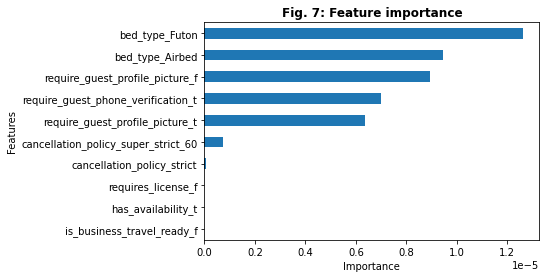

In [28]:
training(X_munich, y_price)

### 